# Calculate and glacier terminus positions at different dates
### Jukes Liu

Files used:
    - Terminus box coordinates and Path Row information (Boxes_coords_pathrows.csv)
    - Terminus chains picked by size (terminuspicks_size_2019_07_24.csv)
    - Terminus chains picked by mass (terminuspicks_mass_2019_07_24.csv)
    - DateTimes of satellite images (datetags.csv)

### Set up: Import packages, read in csv files

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import datetime
import types
import os
import cv2

basepath = '/home/jukes/Documents/Sample_glaciers/'

#set date for the terminus picks analyzed
d8 = '2019_09_03'

In [300]:
#Read in file with box coordinates
box_df = pd.read_csv(basepath+'Boxes_coords_pathrows.csv', sep=',', dtype=str)
box_df = box_df.set_index('BoxID')

#Read in files with terminus picks
#size
termini_df_s = pd.read_csv(basepath+'terminuspicks_size_'+d8+'.csv', sep=',', dtype=str, usecols=[0,1], header=1)
termini_df_s.replace(to_replace ="NaN", value = np.nan)
#mass
termini_df_m = pd.read_csv(basepath+'terminuspicks_mass_'+d8+'.csv', sep=',', dtype=str, usecols=[0,1], header=1)
termini_df_m.replace(to_replace ="NaN", value = np.nan)


#Check number of rows for the termini_dfs:
print(termini_df_m.shape[0])

#look at the DataFrames
#box_df
termini_df_m.head()

1407


,BoxID,Scene
0,001,LC80350052016116LGN00
1,001,LC80310052014242LGN00
2,001,LC80310052016152LGN00
3,001,LC80310052014226LGN00
4,001,LC80340052016109LGN00


### Read in trimmed line centroids OR midpoints and datfile names and add in DataFrame

In [298]:
massorsize="mass"

# centroids_df = pd.read_csv(basepath+'trim_centroids_'+massorsize+'.csv', sep=',', usecols =[1,2,3,4], dtype=str)
# print(centroids_df.shape[0])
# centroids_df.head(10)

midpoints_df = pd.read_csv(basepath+'trim_term_midpoints_'+massorsize+'.csv', sep=',', usecols =[1,2,3,4], dtype=str)
print(midpoints_df.shape[0])
midpoints_df.head(10)

1026


,Scene,BoxID,Mid_X,Mid_Y
0,LC80330052013125LGN01,001,146.0,160.0
1,LC80320052013134LGN03,001,169.0,149.0
2,LC80330052013141LGN01,001,184.0,153.0
3,LC80360042013146LGN00,001,145.0,160.0
4,LC80340052013148LGN00,001,145.0,160.0
5,LC80310052013239LGN00,001,140.0,158.0
6,LC80340052013244LGN00,001,143.0,162.0
7,LC80350052013251LGN00,001,139.0,160.0
8,LC80360042013258LGN00,001,158.0,161.0
9,LC80340052013260LGN00,001,138.0,159.0


In [290]:
#FOR CENTROIDS:
# combined_df = termini_df_m.merge(centroids_df, how = 'inner', on = ['Scene', 'BoxID'])
# combined_df

#FOR MIDPOINTS:
combined_df = termini_df_m.merge(midpoints_df, how = 'inner', on = ['Scene', 'BoxID'])
combined_df

,BoxID,Scene,Mid_X,Mid_Y
0,001,LC80310052014242LGN00,141.0,161.0
1,001,LC80310052016152LGN00,141.0,161.0
2,001,LC80310052014226LGN00,142.0,157.0
3,001,LC80340052016109LGN00,145.0,157.0
4,001,LC80370042015143LGN00,126.0,174.0
5,001,LC80360042015120LGN00,145.0,157.0
6,001,LC80310052015149LGN00,163.0,159.0
7,001,LC80360042016091LGN00,147.0,157.0
8,001,LC80310052014082LGN00,153.0,160.0
9,001,LC80360042015168LGN00,163.0,153.0


### Create DateTime objects for plotting timeseries

In [294]:
#Read in datetags csv as datetime_df
datetime_df = pd.read_csv(basepath+'datetags.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])

#Turn datetimes into DateTime objects
#grab the datetime strings
datetimes = datetime_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
datetime_df['datetimes'] = datetime_objs
#datetime_df

#Merge the datetags into the termini_df dataframes:

termini_df_m = combined_df.merge(datetime_df, how = 'inner', on = 'Scene')
# termini_df_s = pd.merge(termini_df_s, datetime_df, on='Scene', how='left')

In [295]:
print(termini_df_m.shape)
termini_df_m.head()

(1026, 5)


,BoxID,Scene,Mid_X,Mid_Y,datetimes
0,001,LC80310052014242LGN00,141.0,161.0,2014-08-30
1,002,LC80310052014242LGN00,644.0,570.0,2014-08-30
2,004,LC80310052014242LGN00,656.0,600.0,2014-08-30
3,001,LC80310052016152LGN00,141.0,161.0,2016-05-31
4,001,LC80310052014226LGN00,142.0,157.0,2014-08-14


### Calculate distances from centroids/midpoints to the box coordinates and the terminus change rates

In [297]:
#create lists of the subset dataframes (by BoxID) to be concatenated back together at the end
subset_dfs_m = []
# subset_dfs_s = []

#LOOP THROUGH AND PERFORM CALCULATIONS ON THE DATA FOR EACH BOXID
for BoxID in box_df.index:
    box_leftmost_x = np.float(box_df.loc[BoxID, 'leftmost_x'])
    box_midpoint_x = np.float(box_df.loc[BoxID, 'midpoint_x'])
#     print("Box"+BoxID, box_leftmost_x, box_midpoint_x)
    
    #subset the full DataFrames to just the Box of interest
    subset_df_m = termini_df_m[termini_df_m['BoxID'] == BoxID].copy()
#     subset_df_s = termini_df_s[termini_df_s['BoxID'] == BoxID].copy()
    
    #grab the CENTROIDS as an array
#     centroids_x_m = np.array(subset_df_m.loc[:, 'Centroid_X'])
#     #convert to float
#     centroids_x_m = centroids_x_m.astype(float)
    
#     centroids_x_s = np.array(subset_df_s.loc[:, 'Centroid_X_trim'])
#     #convert to float
#     centroids_x_s = centroids_x_s.astype(float)

    #grab the MIDPOINTS as an array
    centroids_x_m = np.array(subset_df_m.loc[:, 'Mid_X'])
    #convert to float
    centroids_x_m = centroids_x_m.astype(float)

    
    #CALCULATE THE X DISTANCE between each centroid and the leftmost point/midpoint of box
    xdist_leftmost_m = centroids_x_m - box_leftmost_x
    xdist_midpoint_m = centroids_x_m - box_midpoint_x
#     xdist_leftmost_s = centroids_x_s - box_leftmost_x
#     xdist_midpoint_s = centroids_x_s - box_midpoint_x

    #add these xdistances to the subset array
    subset_df_m['xdist_leftmost'] = xdist_leftmost_m*15
    subset_df_m['xdist_midpoint'] = xdist_midpoint_m*15
    
#     subset_df_s['xdist_leftmost'] = xdist_leftmost_s*15
#     subset_df_s['xdist_midpoint'] = xdist_midpoint_s*15
    
    
    #CALCULATE TERMINUS CHANGE RATE
    #sort the subset DataFrame by date of delineation from earliest to latest
    subset_df_m = subset_df_m.sort_values(by='datetimes', ascending=True)
#     subset_df_s = subset_df_s.sort_values(by='datetimes', ascending=True)
    
    #create lists to store terminus change rates
    changerates_m = []
#     changerates_s = []

    #For each entry in the subset of the overall DataFrame:
    for i in range(0, len(subset_df_m.index)):
        #print(i)
        #for the earliest entry, change rate is NaN
        if i == 0:
            #grab the date of the terminus position
            t_term_m = list(subset_df_m['datetimes'])[i]
            changerates_m.append(np.NaN)
#             t_term_s = list(subset_df_s['datetimes'])[i]
#             changerates_s.append(np.NaN)
            
        #for all other subsequententries
        if i > 0:
            #grab the date of the terminus position and the previous date
            t_term_m = list(subset_df_m['datetimes'])[i]
            t_term_prev_m = list(subset_df_m['datetimes'])[i-1]
#             t_term_s = list(subset_df_s['datetimes'])[i]
#             t_term_prev_s = list(subset_df_s['datetimes'])[i-1]

            #grab the terminus position and the previous terminus position
            x_term_m = list(subset_df_m['xdist_midpoint'])[i]
            x_term_prev_m = list(subset_df_m['xdist_midpoint'])[i-1]
            
#             x_term_s = list(subset_df_s['xdist_midpoint'])[i]
#             x_term_prev_s = list(subset_df_s['xdist_midpoint'])[i-1]
            
            #calculate the change in terminus position and the change in time
            deltax_m = x_term_m - x_term_prev_m
            deltat_m = t_term_m - t_term_prev_m
            
#             deltax_s = x_term_s - x_term_prev_s
#             deltat_s = t_term_s - t_term_prev_s
            
            #convert deltat object into raw days:
            deltat_m = deltat_m.days
#             deltat_s = deltat_s.days
#             print(BoxID, t_term, deltax, deltat)

            #calculate change rate in meters/day if deltat is not zero
            if deltat_m > 0:
                term_changerate_m = deltax_m/deltat_m
            else:
                #if the change in time is zero, enter 'repeat' as terminus change
                #two images from the same date were analyzed
                term_changerate_m = "repeat date"
                
#             if deltat_s > 0:
#                 term_changerate_s = deltax_s/deltat_s
#             else:
#                 term_changerate_s = "repeat date"

            #add the change rate to the change rate list
            changerates_m.append(term_changerate_m)
#             changerates_s.append(term_changerate_s)
              
    #print the terminus change rates (m/d)
#     for changerate in changerates_m:
#         print("{0:.2f}".format(changerate_m), "m/d")
    
    #add the terminus change rates to the subset df!
    subset_df_m['changerates'] = changerates_m
#     subset_df_s['changerates(m/d)'] = changerates_s
    
    #append the subset dfs to the subset dfs listS
    subset_dfs_m.append(subset_df_m)
#     subset_dfs_s.append(subset_df_s)

#RECOMBINE THE SUBSET DFs
xdist_df_m = pd.concat(subset_dfs_m)
# xdist_df_s = pd.concat(subset_dfs_s)
xdist_df_m = xdist_df_m.dropna()
xdist_df_m

,BoxID,Scene,Mid_X,Mid_Y,datetimes,xdist_leftmost,xdist_midpoint,changerates
138,001,LC80320052013134LGN03,169.0,149.0,2013-05-14,825.0,780.0,38.3333
186,001,LC80330052013141LGN01,184.0,153.0,2013-05-21,1050.0,1005.0,32.1429
158,001,LC80360042013146LGN00,145.0,160.0,2013-05-26,465.0,420.0,-117
130,001,LC80340052013148LGN00,145.0,160.0,2013-05-28,465.0,420.0,0
25,001,LC80310052013239LGN00,140.0,158.0,2013-08-27,390.0,345.0,-0.824176
95,001,LC80340052013244LGN00,143.0,162.0,2013-09-01,435.0,390.0,9
35,001,LC80350052013251LGN00,139.0,160.0,2013-09-08,375.0,330.0,-8.57143
43,001,LC80360042013258LGN00,158.0,161.0,2013-09-15,660.0,615.0,40.7143
57,001,LC80340052013260LGN00,138.0,159.0,2013-09-17,360.0,315.0,-150
100,001,LC80330052013269LGN00,135.0,154.0,2013-09-26,315.0,270.0,-5


Calculate percent cloud in terminus box and append back to xdist_df_m

In [301]:
counter = 0

Boxids = []
scenes = []
percentcloud = []
pixelval_frac = []

for BoxID in box_df.index:
    #set path to the BQA subset bands:
    BQApath = '/media/jukes/jukes1/LS8aws/Box'+BoxID+'/'
#     print(BQApath)
    
    for scene in os.listdir(BQApath):
        if scene.endswith("LGN", -5, -2):
#             print(BQApath+scene)
            images = os.listdir(BQApath+scene+'/')
            
            for image in images:
                if image.endswith('BQA_PS_Box'+BoxID+'.TIF'):
#                     print(image[:21])
                    counter = counter+1
                    
                    #load the subset BQA band and mask out any values that are less than 50000 (clouds)
                    subsetBQA = mpimg.imread(BQApath+scene+'/'+image)
                    totalpixels = np.count_nonzero(subsetBQA)
#                     print("BQA subset total pixels:", totalpixels) 
                    
                    #count the number of cloud pixels
                    cloudBQA = subsetBQA[subsetBQA > 50000]
                    cloudpixels = len(cloudBQA)
#                     print("BQA cloud pixels:", cloudpixels)
                    
                    #calculate divided by the total
                    cloudpercent = "%.1f" % (cloudpixels/totalpixels*100)
#                     print(image, 'Cloud % in box:', cloudpercent)
                                
                    subset_img = mpimg.imread(BQApath+scene+'_B8_PS_Buffer'+BoxID+'.TIF')
                    avgpixval = np.average(subset_img)
                    maxpixval = np.max(subset_img)
                    avg_max = "%.0f" % (avgpixval/maxpixval*100)
#                     print(avg_max)
                    
                    if avgpixval == 0.0:
                        pixelval_frac.append('0')
                        scenes.append(image[:21])
                        percentcloud.append(cloudpercent)
                        Boxids.append(BoxID)
                    else:
                        pixelval_frac.append(avg_max)
                        scenes.append(image[:21])
                        percentcloud.append(cloudpercent)
                        Boxids.append(BoxID)
                    
print(counter, len(scenes), len(percentcloud), len(pixelval_frac), len(Boxids))
scenestats_df = pd.DataFrame(list(zip(scenes, Boxids, percentcloud, pixelval_frac)),
              columns=['Scene','BoxID','Cloudpercent', 'Avgpixel_percent'])

/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


1260 1260 1260 1260 1260


Join the 2 dataframes on Scene and BoxID

In [302]:
xdist_total = pd.merge(xdist_df_m, scenestats_df,  how='inner', on = ['Scene','BoxID'])

In [303]:
xdist_total = xdist_total.dropna()

#### Export data to a terminus change dataframe

In [304]:
xdist_total.to_csv(path_or_buf = '/home/jukes/Documents/Sample_glaciers/terminuschange_'+d8+"_"+massorsize+'.csv', sep=',')

Change name back to xdist_m_df for the following code

In [305]:
xdist_df_m = xdist_total

### Plot terminus position and terminus change vs. datetime for each BoxID

In [307]:
#set dictionaries to call info in DataFrames for each individual BoxID
termini_bybox_m = {}
# termini_bybox_s = {}

#grab dataframe for each individual BoxID
for BoxID in box_df.index:
    #grab termini pick info for that BoxID
    termini_bybox_df_m = xdist_df_m[xdist_df_m['BoxID'] == BoxID].copy()
#     termini_bybox_df_s = xdist_df_s[xdist_df_s['BoxID'] == BoxID].copy()
    #update to dictionaries
    termini_bybox_m.update( {BoxID: termini_bybox_df_m} )
#     termini_bybox_s.update( {BoxID: termini_bybox_df_s} )

In [198]:
# df_BOI_m.Cloudpercent

Plot for each BoxID

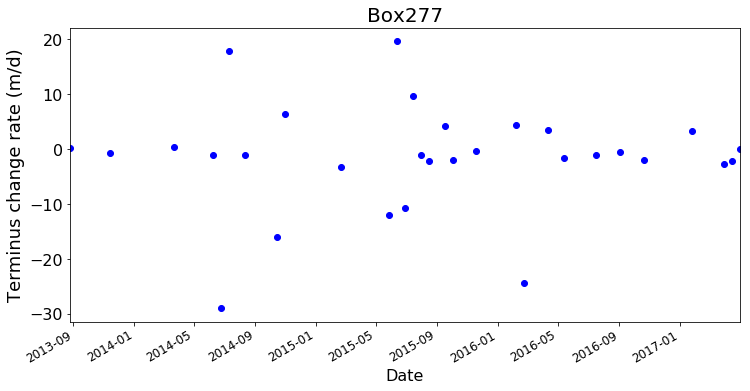

In [319]:
#SET BOX OF INTEREST (BOI) to plot
BOI = '277'
massorsize = "mass"
metric = "terminus_highest"+massorsize+"/"
downloadpath = '/media/jukes/jukes1/LS8aws/'
imagepath = downloadpath+"Box"+BOI+"/rotated/resized/"

#grab df for BOI 
df_BOI_m = termini_bybox_m[BOI]
# df_BOI_s = termini_bybox_s[BOI]

#drop those with terminus change rates > 100?
# df_BOI_m = df_BOI_m[df_BOI_m.changerates != 'repeat date']
# df_BOI_m.changerates = df_BOI_m.changerates.astype(float)
# df_BOI_m = df_BOI_m[df_BOI_m.changerates > 100.0]

#PLOT TERMINUS POSITION 
# ax = df_BOI_m.plot(x='datetimes', y='xdist_midpoint', style='mo', figsize=(12,6), legend=None)
# # df_BOI_s.plot(x='datetimes', y='xdist_midpoint', style='co-', ax=ax)
# plt.ylabel('Terminus position (m)', fontsize=18)

#PLOT TERMINUS CHANGE
# drop any repeat date values since they will not plot terminus changes properly
df_BOI_m = df_BOI_m[df_BOI_m.changerates != 'repeat date']

ax = df_BOI_m.plot(x='datetimes', y='changerates', style='bo', figsize=(12,6), legend=None)
plt.ylabel('Terminus change rate (m/d)', fontsize=18)

#PLOT PERCENT CLOUD
# df_BOI_m.Cloudpercent = df_BOI_m.Cloudpercent.astype(float)
# ax = df_BOI_m.plot(x='datetimes', y='Cloudpercent', style='co', figsize=(12,6), legend=None)
# plt.ylabel('% Cloud', fontsize=18)

#PLOT AVGPIXEL PERCENT
# df_BOI_m.Avgpixel_percent = df_BOI_m.Avgpixel_percent.astype(float)
# ax = df_BOI_m.plot(x='datetimes', y='Avgpixel_percent', style='ko', figsize=(12,6), legend=None)
# plt.ylabel('Avg pixel value (% of max)', fontsize=18)


#GENERAL PLOT PARAMETERS
plt.title("Box"+BOI, fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
# plt.legend(labels=['Mass' ,'Size'])
# plt.legend(labels=['Mass'])

#SAVE FIGURE
# plt.savefig(basepath+"Termposition_LS8_m_Box"+BOI+".png", dpi=200)
plt.savefig(basepath+"Termchangerates_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"Cloudpercent_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"Avgpixval_LS8_m_Box"+BOI+".png", dpi=200)

plt.show()


_Remnant code to plot terminus change values over the terminus position points:_

In [202]:
# #LABEL EACH POINT BY TERMINUS CHANGE RATE
# for i, changerate_m in enumerate(df_BOI_m.index):
# #     print(type(changerate), changerate)
#     #If the rate is a float (number or Nan), format it
#     if isinstance(changerate_m, float):
#         txt = str("{0:.2f}".format(changerate_m))
#         #If it's positive, add a + for clarity:
#         if changerate_m > 0:
#             txt = "+"+txt
#         #don't plot the nans
#         if np.isnan(changerate_m):
#             txt = " "
#     #for others, plot the string
#     else:
#         txt = str(changerate_m)
#     plt.annotate(txt, 
#                  xy=(list(df_BOI_m['datetimes'])[i] ,list(df_BOI_m['xdist_midpoint'])[i]), 
#                  fontsize=12,
#                  xytext=(6 ,4), 
#                  textcoords='offset points',
#                  color='m')
# for i, changerate_s in enumerate(df_BOI_s.index):
# #     print(type(changerate), changerate)
#     #If the rate is a float (number or Nan), format it
#     if isinstance(changerate_s, float):
#         txt = str("{0:.2f}".format(changerate_s))
#         #If it's positive, add a + for clarity:
#         if changerate_s > 0:
#             txt = "+"+txt
#         #don't plot the nans
#         if np.isnan(changerate_s):
#             txt = " "
#     #for others, plot the string
#     else:
#         txt = str(changerate_s)
#     plt.annotate(txt, 
#                  xy=(list(df_BOI_s['datetimes'])[i] ,list(df_BOI_s['xdist_midpoint'])[i]), 
#                  fontsize=12,
#                  xytext=(6 ,-10), 
#                  textcoords='offset points',
#                  color='c')

### Plot image and seglines

In [193]:
#add dat file x and ys in as dataframes:

#get list of images
print("Box"+BOI)
pathtoimgs = '/media/jukes/jukes1/LS8aws/Box'+BOI+'/rotated/resized/'
imgfiles = os.listdir(pathtoimgs)
images = []
term_dats = []
imgnames = []

for imgfile in imgfiles:
    #grab image files and append to images list
    if imgfile.endswith(BOI+".png"):
        print(imgfile)
        image = mpimg.imread(pathtoimgs+imgfile)
        
        #grab dat files
        pathtodat = pathtoimgs+imgfile[0:-4]+".pgm_max_gaussian/terminus_highestmass/"
        datfiles = os.listdir(pathtodat)
        
        #if there is a dat file:
        if len(datfiles) > 0:
            #grab the dat file and read it in and append to the list
            datfile = datfiles[0]
            print(datfile)
            term_dat = np.loadtxt(pathtodat+datfile)
            term_dats.append(term_dat)
            print(term_dat.shape)
            #append the image name
            images.append(image)
            imgnames.append(imgfile)
        else:
            print("NO DAT FILE FOUND")
            

print(len(term_dats), len(images))

Box001
crop_R_LC80340052015106LGN00_B8_PS_Buffer001.png
terminus_highestmass_016.dat
(50, 2)
crop_R_LC80340052015218LGN00_B8_PS_Buffer001.png
terminus_highestmass_013.dat
(59, 2)
crop_R_LC80340052015202LGN00_B8_PS_Buffer001.png
terminus_highestmass_019.dat
(79, 2)
crop_R_LC80340052013148LGN00_B8_PS_Buffer001.png
terminus_highestmass_007.dat
(59, 2)
crop_R_LC80340052017095LGN00_B8_PS_Buffer001.png
terminus_highestmass_008.dat
(119, 2)
crop_R_LC80340052014183LGN00_B8_PS_Buffer001.png
terminus_highestmass_017.dat
(27, 2)
crop_R_LC80340052015266LGN00_B8_PS_Buffer001.png
terminus_highestmass_014.dat
(74, 2)
crop_R_LC80340052016253LGN00_B8_PS_Buffer001.png
terminus_highestmass_049.dat
(43, 2)
crop_R_LC80340052015090LGN00_B8_PS_Buffer001.png
terminus_highestmass_032.dat
(55, 2)
crop_R_LC80340052014263LGN00_B8_PS_Buffer001.png
terminus_highestmass_048.dat
(41, 2)
crop_R_LC80340052015122LGN00_B8_PS_Buffer001.png
terminus_highestmass_048.dat
(41, 2)
crop_R_LC80340052016141LGN00_B8_PS_Buffer001.p

crop_R_LC80340052015202LGN00_B8_PS_Buffer001.png average pixel value: 0.28562254
crop_R_LC80340052017095LGN00_B8_PS_Buffer001.png average pixel value: 0.36437362
crop_R_LC80340052016125LGN00_B8_PS_Buffer001.png average pixel value: 0.21688671
crop_R_LC80340052016189LGN00_B8_PS_Buffer001.png average pixel value: 0.24517418
crop_R_LC80340052016205LGN00_B8_PS_Buffer001.png average pixel value: 0.25504142
crop_R_LC80340052016173LGN00_B8_PS_Buffer001.png average pixel value: 0.31532618
crop_R_LC80340052014247LGN00_B8_PS_Buffer001.png average pixel value: 0.3339636
crop_R_LC80340052015154LGN00_B8_PS_Buffer001.png average pixel value: 0.2765246
crop_R_LC80340052016157LGN00_B8_PS_Buffer001.png average pixel value: 0.27350658
crop_R_LC80340052016237LGN00_B8_PS_Buffer001.png average pixel value: 0.34981853
crop_R_LC80340052016221LGN00_B8_PS_Buffer001.png average pixel value: 0.26537254
Lines: 11


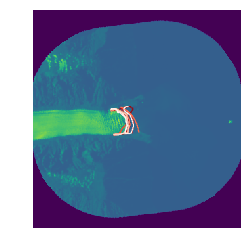

In [249]:
#imgplt = plt.imshow(images[40])
imgplt = plt.imshow(mpimg.imread('/home/jukes/Documents/Sample_glaciers/Box001/rotated_images/final/crop_PS_LC08_L1TP_031005_20180825_20180829_01_T1_B8_Buffer001cut.png'))
final_imgnames = []

xs = []
ys = []
for i in range(0, len(images)):
#     print(i)
    index = i
    #imgplt = plt.imshow(images[index])#cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))\
    avgpxval = np.average(images[index])
   
    #if the pixel value is above a threshold, then grab the terminus
    if avgpxval < 0.37:
        final_imgnames.append(imgnames[index])
        print(imgnames[index], "average pixel value:", avgpxval)
        term = term_dats[index]
        term_xs = []
        term_ys = []

        #grab x and y values for the terminus line
        for j in term:
            x, y = (j[0], j[1])
            term_xs.append(x)
            term_ys.append(y)
        
        xs.append(term_xs)
        ys.append(term_ys)

#create dataframe with the term line coordinates and sort by date
termlines_df = pd.DataFrame(
    {'imgnames': final_imgnames,
     'X': xs,
     'Y': ys
    })

termlines_df = termlines_df.sort_values(by=['imgnames'])
termlines_df.head()

# #create reversed red color map for the lines
n=len(termlines_df.index)
print("Lines:", n)
colors = pl.cm.Reds_r(np.linspace(0,1,n))
col_count = 0

name = list(termlines_df['imgnames'])
x_final = list(termlines_df['X'])
y_final = list(termlines_df['Y'])

#plot each termline
for a in range(0, n):
    x, y = x_final[a], y_final[a]
    pl.plot(x, y, color=colors[col_count], linewidth=1)
    col_count = col_count+1

plt.axis("off")
plt.savefig(basepath+"AGU2019_autolines_Box"+BOI+".png", dpi=300)

_Remnant code on plotting teminus changes:_

In [435]:
# #PLOT:
# plt.figure(figsize=(12, 8))
# plt.plot(changerates.keys(), changerates.values(),'rx', markersize=15)

# #Label the points by the change rate (m/d)
# for i, changerate in enumerate(changerates.values()):
#     txt = "{0:.2f}".format(changerate)
#     plt.annotate(txt, xy=(list(changerates.keys())[i], list(changerates.values())[i]), fontsize=16)

# plt.title("Box"+BOI, fontsize=20)
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Terminus change (m/d)', fontsize=18)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=16)
# plt.gca().invert_yaxis()

# plt.show()